In [18]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

data = pd.read_csv("C:\\Users\\PC COMPUTER\\Desktop\\WAT\\Semestr 5\\Programowanie funkcyjne\\Laboratoria\\Lab4\\lab4\\covid_data.csv", delimiter=',', usecols=["continent", "location", "date", "new_cases_per_million"], header=0)
data = data.dropna().reset_index(drop=True)
graph = pd.read_csv("C:\\Users\\PC COMPUTER\\Desktop\\WAT\\Semestr 5\\Programowanie funkcyjne\\Laboratoria\\Lab4\\lab4\\covid_data.csv", delimiter=',', usecols=["iso_code", "continent", "location", "date", "total_cases_per_million", "new_cases_per_million", 'total_deaths'], header=0).dropna().reset_index(drop=True)

# print(data)

data = data[data.continent.str.contains('Asia',case=False)]
data['date'] = pd.to_datetime(data['date'])
data['period'] = data['date'].dt.month
##na potrzebe plot4
graph4 = data
graph4['total_deaths'] = graph['total_deaths']

data = data.loc[(data['period']>=4) & (data['period']<=10)]
##na potrzebe plot3
graph3 = data

data = data.groupby(['location', 'period']).mean()
data = data.reset_index()[['location', 'period', 'new_cases_per_million']]

low = data.groupby('period', as_index=0)['new_cases_per_million'].min()
high = data.groupby('period', as_index=0)['new_cases_per_million'].max()
med = data.groupby('period', as_index=0)['new_cases_per_million'].max()

groups = pd.DataFrame(data, columns = ['period', 'low', 'mediumLow','mediumHigh', 'high'])
groups['period'] = data['period']
groups['low'] = low['new_cases_per_million']
groups['high'] = high['new_cases_per_million']
groups['mediumLow'] = (high['new_cases_per_million'] - low['new_cases_per_million'])*(1/3)
groups['mediumHigh'] = (high['new_cases_per_million'] - low['new_cases_per_million'])*(2/3)
groups = groups.dropna()

result = pd.merge(data, groups)

result.loc[(result.new_cases_per_million < result.mediumLow), 'group'] = 1
result.loc[(result.new_cases_per_million > result.mediumLow) & (result.new_cases_per_million < result.mediumHigh), 'group'] = 2
result.loc[(result.new_cases_per_million > result.mediumHigh), 'group'] = 3

result = result.drop(['new_cases_per_million', 'low', 'mediumLow', 'mediumHigh', 'high'], axis=1)
result = result.loc[(result['period']==4) | (result['period']==10)]
result = result.reset_index()[['location', 'period', 'group']]

result = result.sort_values(by=['location', 'period'])
result = result.reset_index()[['location', 'period', 'group']]
result = result.groupby('location').last()['group'] - result.groupby('location').first()['group']
result = result.reset_index()[['location', 'group']]

result.loc[(result.group < 0), 'promotion'] = True
result = result.drop(['group'], axis=1)
result = result.dropna()
result = result.reset_index()[['location']]

In [28]:
plot0 = result
fig = px.choropleth(data_frame=plot0,
                    locations='location',
                    locationmode='country names',
                    color='location',
                    scope='asia',
                    hover_data=['location'],
                    labels={'Rozpatrywany kraj': 'Liczba przypadków zarażenia'},
                    title='Wynik zadania 2 (mapa jest niedokładna i nie odróżnia Singapuru od Malezji)',
                    color_continuous_scale='turbo')
fig.show()

# Singapur niestety nie jest odróżniany od malezji na mapie

In [22]:
### Suma wszystkich zarażeń z podziałem na poszczególne kraje

plot1 = graph.groupby(['iso_code']).sum().reset_index().sort_values(by=['total_cases_per_million'], ascending=False)

fig = px.choropleth(data_frame=plot1,
                    locations='iso_code',
                    locationmode='ISO-3',
                    color='total_cases_per_million',
                    hover_data=['iso_code', 'total_cases_per_million'],
                    labels={'Rozpatrywany kraj': 'Liczba przypadków zarażenia'},
                    title='Suma wszystkich zarażeń z podziałem na poszczególne kraje',
                    color_continuous_scale='turbo')

fig.show()

In [23]:
plot3 = graph3.groupby(['location']).mean().reset_index()

fig = px.choropleth(data_frame=plot3,
                    locations='location',
                    locationmode='country names',
                    scope='asia',
                    color='new_cases_per_million',
                    hover_data=['location', 'new_cases_per_million'],
                    labels={'Rozpatrywany kraj': 'Liczba przypadków zarażenia'},
                    title='Średnia nowych przypadków zarażenia w danym azjatyckim kraju w okresie Kwiecień 2020 - Wrzesień 2020',
                    color_continuous_scale='turbo')

fig.show()

In [24]:
plot4 = graph4.groupby(['location', 'period', 'total_deaths']).size().reset_index()


fig = px.choropleth(data_frame=plot4,
                    locations='location',
                    locationmode='country names',
                    scope='asia',
                    color='total_deaths',
                    hover_data=['location', 'period', 'total_deaths'],
                    labels={'Rozpatrywany kraj': 'Liczba przypadków zarażenia'},
                    color_continuous_scale='turbo')

fig.show()

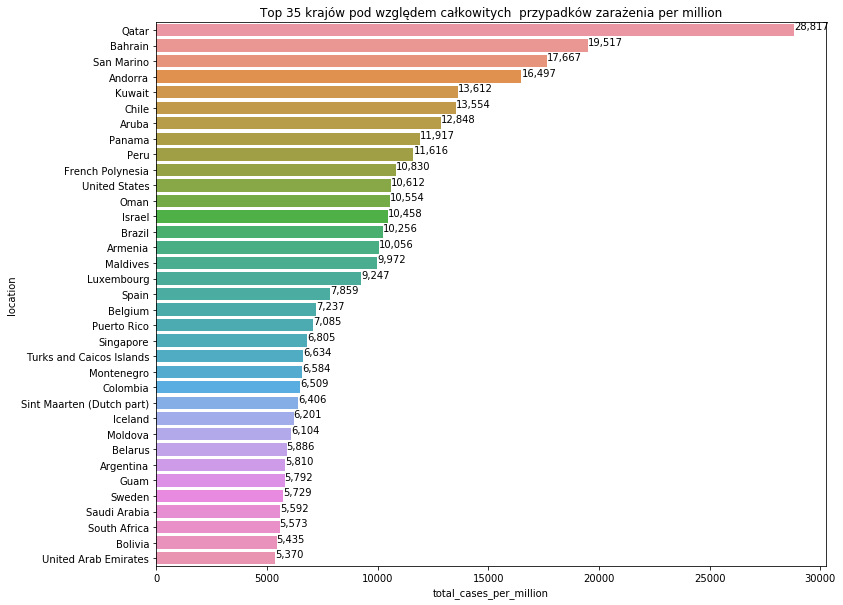

In [25]:
# Top 35 krajów pod względem 'total_cases_per_million'

plot2 = graph.groupby(['location']).mean().reset_index().sort_values(by=['total_cases_per_million'], ascending=False).head(35)

plt.figure(figsize=(12,10))
plt.title('Top 35 krajów pod względem całkowitych  przypadków zarażenia per million')
plot = sns.barplot(plot2['total_cases_per_million'], plot2['location'])
for i,(value,name) in enumerate(zip(plot2['total_cases_per_million'],plot2['location'])):
    plot.text(value,i-0.05,f'{value:,.0f}',size=10)
plt.show()

In [27]:
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Średnia nowych przypadków zarażenia na million mieszkańców z podziałem na miesiące w krajach azjatyckich", style={'test-align': 'center'}),
    dcc.Dropdown(id='slct_year',
                 options=[
                     {"label": "Styczeń", "value": 1},
                     {"label": "Luty", "value": 2},
                     {"label": "Marzec", "value": 3},
                     {"label": "Kwiecień", "value": 4},
                     {"label": "Maj", "value": 5},
                     {"label": "Czerwiec", "value": 6},
                     {"label": "Lipiec", "value": 7},
                     {"label": "Siepień", "value": 8},
                     {"label": "Wrzesień", "value": 9},
                     {"label": "Październik", "value": 10},
                     {"label": "Listopad", "value": 11},
                     {"label": "Grudzień", "value": 12}],
                 multi=False,
                 value=1,
                 style={"width": "40%"}
                 ),
    html.Div(id='output_container', children=[]),
    html.Br(),
    dcc.Graph(id='Covid_map', figure={})
])

@app.callback(
    [Output(component_id='output_container', component_property='children'),
     Output(component_id='Covid_map', component_property='figure')],
    [Input(component_id='slct_year', component_property='value')]
)

def update_graph(option_slctd):
    print(option_slctd)
    print(type(option_slctd))

    container = "Użytkownik wybrał miesiąc: {}".format(option_slctd)

    plot4 = graph4.groupby(['location', 'period'])['new_cases_per_million'].mean().round(4).reset_index()

    plott4 = plot4[plot4['period'] == option_slctd]

    fig = px.choropleth(data_frame=plott4,
                        locations='location',
                        locationmode='country names',
                        scope='asia',
                        color='new_cases_per_million',
                        hover_data=['location', 'period', 'new_cases_per_million'],
                        labels={'Rozpatrywany kraj': 'Liczba przypadków zarażenia'},
                        title='Diagram w postaci heatmapy reprezentujący ognisko nowych zarażeń',
                        color_continuous_scale='turbo')


    return container, fig


app.run_server(debug=True)

print(graph4.groupby(['location', 'period'])['total_deaths'].mean().reset_index())


Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


SystemExit: 1